<a href="https://colab.research.google.com/github/LucasPequenoSterzeck/Machine_Learning_LPS/blob/main/PyTorch_Jovian_ZeroToGANs/Class_02/MNIST_Train_Torch_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Notebook destined to train in mnist dataset

In [17]:
# Lib's torch import:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torchvision.datasets import MNIST
from torch.utils.data import random_split
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt


In [9]:
# parameters
batch_size = 128
learning_rate = 0.001

# others
input_size = 28*28 # Pixel's Weight x Pixel's Length
num_classes = 10 # 0 to 9 - 10 classes/possibilites

In [11]:
# Donwload the dataset MINIST
dataset = MNIST(root='data/', train=True, transform=transforms.ToTensor(), download=True)

# Train, val and test dataset
train_ds, val_ds = random_split(dataset, [50000, 10000])
test_ds = MNIST(root='data/', train=False, transform=transforms.ToTensor())

# Dataloaders
train_loader = DataLoader(train_ds, batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size*2)
test_loader = DataLoader(test_ds, batch_size*2)

Label of image:  7
Dimension:  torch.Size([1, 28, 28])


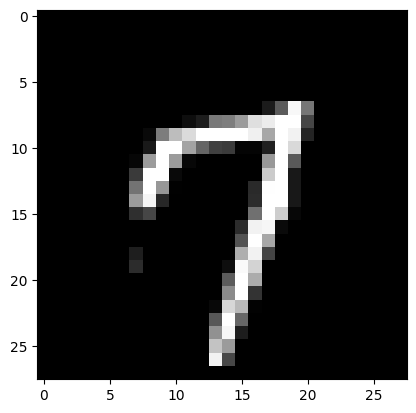

In [22]:
# test data:
img, lab = train_ds[0]
print('Label of image: ',lab)
print('Dimension: ',img.shape)
plt.imshow(img[0], cmap='gray')


# Extend a Class of TORCH.NN

In [35]:
# Creating class MnistModel from Torch.NN

class MnistModel(nn.Module):
  def __init__(self):
    super().__init__()
    self.linear = nn.Linear(input_size, num_classes)

  def forward(self, xb):
    xb = xb.reshape(-1, 784)
    out = self.linear(xb)
    return out

  def training_step(self, batch):
    img, lab = batch
    out = self(img)
    loss = F.cross_entropy(out, lab)
    return loss

  def validation_step(self, batch):
    img, lab = batch
    out = self(img)
    loss = F.cross_entropy(out, lab)
    acc = accuracy(out, lab)
    return {'val_loss': loss.detach(), 'val_acc': acc.detach()}

  def validation_epoch_end(self, outputs):
    batch_losses = [x['val_loss'] for x in outputs]
    epoch_losses = torch.stack(batch_losses).mean()
    batch_accs = [x['val_acc'] for x in outputs]
    epoch_acc = torch.stack(batch_accs).mean()
    return {'val_loss': epoch_losses.item(), 'val_acc': epoch_acc.item()}

  def epoch_end(sefl, epoch, result):
    print(f"-> Epoch [{epoch}]  |  Val_loss: {round(result['val_loss'],4)}  |  Val_acc: {round(result['val_acc'],4)}")

# declare the model
model = MnistModel()

# Sub classes
def accuracy(out, lab):
  _, preds = torch.max(out, dim=1)
  return torch.tensor(torch.sum(preds == lab).item() / len(preds))

def evaluate(model, val_loader):
  out = [model.validation_step(batch) for batch in val_loader]
  return model.validation_epoch_end(out)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
  history = []
  opt = opt_func(model.parameters(), lr)
  for epoch in range(epochs):
    # Training Phase
    for batch in train_loader:
      loss = model.training_step(batch)
      loss.backward()
      opt.step()
      opt.zero_grad()
    # Validation Phase
    result = evaluate(model, val_loader)
    model.epoch_end(epoch, result)
    history.append(result)
  return history

In [36]:
evaluate(model, val_loader)

{'val_loss': 2.3065097332000732, 'val_acc': 0.1181640625}

In [37]:
history = fit(5, 0.001, model, train_loader, val_loader)

-> Epoch [0]  |  Val_loss: 1.9223  |  Val_acc: 0.6223
-> Epoch [1]  |  Val_loss: 1.657  |  Val_acc: 0.7239
-> Epoch [2]  |  Val_loss: 1.4593  |  Val_acc: 0.7653
-> Epoch [3]  |  Val_loss: 1.3096  |  Val_acc: 0.7868
-> Epoch [4]  |  Val_loss: 1.1943  |  Val_acc: 0.7994


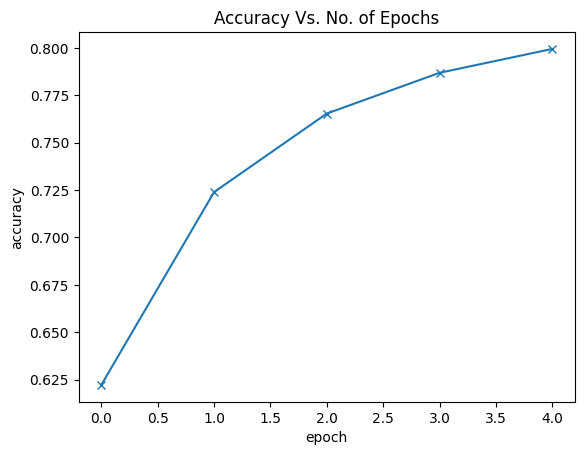

In [38]:
accuracies = [r['val_acc'] for r in history]
plt.plot(accuracies, '-x')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Accuracy Vs. No. of Epochs')
plt.show()